In [42]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from train_utils import *
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
from copy import deepcopy

import uproot
from root_pandas import read_root


import socket
my_hostname=socket.gethostbyaddr(socket.gethostname())[0]
print('You are running on ', my_hostname)

You are running on  wudangshan


In [43]:
# Load the data

def load_data(debug=False):
    idir = '{}'.format('/nfs/user/pvischia/tth/dnn/' if 'cism.ucl.be' in my_hostname else './')
    file_tth = "{}/tree_2lss1tau.root".format(idir)
    key = "Friends"
    data_tth_orig = read_root(file_tth, key)
    if debug:
        data_tth_orig.describe()
    return data_tth_orig

In [44]:
# De-jag the data with respect to the jets

def dejag_data(data, debug=False):
    test=data['SelJet_pt']
    l = [len(i) for i in test]
    maxl = max(l)

    for lab in ['pt', 'eta', 'phi', 'mass', 'isBtag', 'isFromHadTop', 'btagDeepFlavB']:
        label='SelJet_%s'%lab
        tempLab=data[label]
        data.drop([label], axis=1, inplace=True)
        out = pd.DataFrame(tempLab.tolist(),columns=[ 'SelJet%s_%s'%(i, lab) for i in range(maxl)])
        data = pd.concat([data, out], axis=1)
    return data


In [45]:
# Remove ill-defined mass columns
def remove_masses(data, debug=False):
    for lab in data.columns:
        if 'mass' in lab:
            data.drop([lab], axis=1, inplace=True)
    return data

In [46]:
def load_feature_names(useJets=0, debug=False):
    thevars=[
            'Lep1_pt', 
            'Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi',
             'nSelJets',
             'met', 'met_phi', 
             'HTT_score', 
             'Hj_tagger_hadTop',
             'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet',
             'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dPhiBB_LLframe_2lss',
             'dEtaBB_LLframe_2lss',
             'dEtaBB_2lss',
             'mTTH_2lss1tau',
             'theta_higgs_ttbar_TTHsystem_2lss1tau',
             'thetaTopTop_ttbarframe_2lss1tau', 
             'Tau_pt', 'Tau_eta', 'Tau_phi'
            ]
    if useJets>0:
        for i in range(useJets):
            thevars.append('SelJet%s_pt'%i)
            thevars.append('SelJet%s_eta'%i)
            thevars.append('SelJet%s_phi'%i)
            #thevars.append('SelJet%s_mass'%i)
            thevars.append('SelJet%s_isBtag'%i)
            thevars.append('SelJet%s_isFromHadTop'%i)
            thevars.append('SelJet%s_btagDeepFlavB'%i)
    if debug:
        print('Training features:', thevars)
        
    return thevars


In [47]:
def get_train_and_test(data, features, oddevensplit=False, fillna=False, debug=False):
    labs=deepcopy(features)
    if oddevensplit:
        labs.append('event')
    bkg = data[labs]
    sig = data[labs]

    if fillna:
        bkg.fillna(0, inplace=True)
        sig.fillna(0, inplace=True)


    wgtbkg=pd.DataFrame(data['weight_SM'].tolist(), columns=['weight'])
    wgtsig=pd.DataFrame(data['weight_CP_odd'].tolist(), columns=['weight'])

    labbkg = pd.DataFrame(np.zeros_like(bkg[features[0]]).tolist(), columns=['label'])
    labsig = pd.DataFrame(np.ones_like(bkg[features[0]]).tolist(), columns=['label'])

    bkg = pd.concat([bkg, wgtbkg, labbkg], axis=1)
    sig = pd.concat([sig, wgtsig, labsig], axis=1)

    sig['weight'] = sig['weight'].apply(lambda x: x if x <10. else 10.)

    labelled_set=pd.concat([sig, bkg], axis=0)
    if False:
        sns.pairplot(labelled_set, hue='label')
    if oddevensplit:
        labs.append('weight')
        X=labelled_set[labs]
        y=labelled_set['label']
        weight=labelled_set['weight']
        if debug:
            pd.set_option('display.max_columns', None)
            print(bkg.head())
            print(sig.head())

        X_wgt=X['weight']

        X_train=X[X['event']%2 == 0]
        X_test =X[X['event']%2 != 0]
        y_train=y[X['event']%2 == 0]
        y_test =y[X['event']%2 != 0]
        
        X_train_wgt=X_train['weight']
        X_train=X_train.drop(['weight'], axis=1, inplace=False)
        X_train=X_train.drop(['event'], axis=1, inplace=False)

        X_test_wgt=X_test['weight']
        X_test=X_test.drop(['weight'], axis=1, inplace=False)
        X_test=X_test.drop(['event'], axis=1, inplace=False)

        return {'X_train'     : X_train,
                'X_test'      : X_test, 
                'X_train_wgt' : X_train_wgt,
                'X_test_wgt'  : X_test_wgt,
                'y_train'     : y_train,
                'y_test'      : y_test 
               }
    else:
        labelled_set=shuffle(labelled_set)
        labs.append('weight')
        X=labelled_set[labs]
        y=labelled_set['label']
        weight=labelled_set['weight']
        if debug:
            pd.set_option('display.max_columns', None)
            print(bkg.head())
            print(sig.head())

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1534534, shuffle=True)

        X_train_wgt=X_train['weight']
        X_train=X_train.drop(['weight'], axis=1, inplace=False)
        X_test_wgt=X_test['weight']
        X_test=X_test.drop(['weight'], axis=1, inplace=False)

        return {'X_train'     : X_train,
                'X_test'      : X_test, 
                'X_train_wgt' : X_train_wgt,
                'X_test_wgt'  : X_test_wgt,
                'y_train'     : y_train,
                'y_test'      : y_test
               }
        #train_dmatrix = xgb.DMatrix(data=X_train,label=y_train,weight=X_train_wgt)
        #test_dmatrix = xgb.DMatrix(data=X_test,label=y_test,weight=X_test_wgt)

    #perm = np.random.permutation(len(X_train))
    #X_train = X_train[perm]
    #y_train = y_train[perm]
    #X_train_wgt = X_train_wgt[perm]

    #perm = np.random.permutation(len(X_train))
    #X_test = X_test[perm]
    #y_test = y_test[perm]
    #X_test_wgt = X_test_wgt[perm]


In [48]:
def plot_features(X, y, wgt, features, label):
    fix, axs= plt.subplots(10,10, figsize=(40,40))
    axs = axs.ravel()

    for i,ax in enumerate(axs):
        if i >= len(features):
            continue
        var=features[i]
        if var=='weight':
            continue
        ax=axs[i]
        #ax.hist(X_train[var], label='%s'%var)
        ax.hist(X[var][y[:]==0 ], weights=wgt[y[:]==0 ], density=True, alpha=0.5, bins=20)
        ax.hist(X[var][y[:]==1 ], weights=wgt[y[:]==1 ], density=True, alpha=0.5, bins=20)
        #ax.set_yscale('log')
        ax.set_title('%s dataset'%label)
        ax.set_xlabel(var)
    plt.show()
    plt.hist(wgt[y[:]==0 ], alpha=0.5, bins=np.linspace(0,20,200))
    plt.yscale("log")
    plt.hist(wgt[y[:]==1 ], alpha=0.5, bins=np.linspace(0,20,200))
    plt.title('%s dataset')
    plt.show()

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)


In [49]:
# Load the data
debug=False
data_tth_orig = load_data(debug=debug)
data_tth=data_tth_orig # save the original
data_tth=dejag_data(data_tth, debug=debug)
data_tth=remove_masses(data_tth, debug=debug)
    
the_initial_vars=load_feature_names(useJets=0, debug=debug) # add "useJets" quadrimomenta of jets


In [57]:
# Train a single model (the basic template)

def train_single_model(data, features, oddevensplit=True, fillna=False, debug=False):
    # Start with a first thing with all variables
    datasets= get_train_and_test(data, features, oddevensplit=oddevensplit, fillna=fillna, debug=debug)
    X_train     = datasets['X_train']
    X_test      = datasets['X_test']
    X_train_wgt = datasets['X_train_wgt']
    X_test_wgt  = datasets['X_test_wgt']
    y_train     = datasets['y_train']
    y_test      = datasets['y_test']

    if debug:
        plot_features(X_train, y_train, X_train_wgt, the_initial_vars, 'training')
        plot_features(X_test , y_test , X_test_wgt , the_initial_vars, 'test')
    # WORKING PROTOTYPE: xg_class = xgb.XGBClassifier(n_estimators=120, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, gamma=1)
    xg_class = xgb.XGBClassifier(n_estimators=120, max_depth=4, learning_rate=0.1, subsample=0.8, colsample_bytree=1, gamma=1)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xg_class.fit(X=X_train,y=y_train,eval_metric=["error", "logloss"], early_stopping_rounds=10, eval_set=eval_set,sample_weight=X_train_wgt,sample_weight_eval_set=[X_train_wgt, X_test_wgt])

    preds_train = xg_class.predict_proba(X_train)[:,0]
    preds_test = xg_class.predict_proba(X_test)[:,0]

    #preds_train=np.argmax(xg_class.predict_proba(X_train), axis=1)
    #preds_test =np.argmax(xg_class.predict_proba(X_test), axis=1)

    preds_cat_train = xg_class.predict(X_train)
    preds_cat_test  = xg_class.predict(X_test)
    # ROC curves
    auc_train=plot_roc(y_train, preds_train, sample_weight=X_train_wgt, label='training', plot=False, debug=False)
    auc_test=plot_roc(y_test, preds_test, sample_weight=X_test_wgt, label='test', plot=False, debug=False)

    accuracy_train = accuracy_score(y_train, preds_cat_train,sample_weight=X_train_wgt)
    print("Accuracy (train): %.2f%%" % (accuracy_train * 100.0))
    accuracy_test = accuracy_score(y_test, preds_cat_test, sample_weight=X_test_wgt)
    print("Accuracy (test): %.2f%%" % (accuracy_test * 100.0))

    if debug:
        xgb.plot_importance(xg_class)
        plt.figure(figsize = (16, 12))
        plt.show()        
        results = xg_class.evals_result()
        epochs = len(results['validation_0']['logloss'])
        x_axis = range(0, epochs)
        # plot log loss
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
        ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
        ax.legend()
        plt.ylabel('Log Loss')
        plt.title('XGBoost Log Loss')
        plt.show()
        # plot classification error
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0']['error'], label='Train')
        ax.plot(x_axis, results['validation_1']['error'], label='Test')
        ax.legend()
        plt.ylabel('Classification Error')
        plt.title('XGBoost Classification Error')
        plt.show()

        cm = confusion_matrix(y_test, preds_cat_test, sample_weight=X_test_wgt)
        plot_confusion_matrix(cm, ['CP odd', 'CP even'])
        plot_rel_pred(y_test, preds_test, 'test')
        plot_pred(y_test, preds_test, 'test')
        plot_weights(X_test_wgt, y_test, 'test')
        
    return {'auc_train': auc_train, 'auc_test': auc_test, 'model': xg_class, 'features': features, 'sorted_importance': dict(sorted(xg_class.get_booster().get_score(importance_type='weight').items(), key=lambda item: item[1])) }

In [ ]:
# Run the full hyperparameters optimization for a single set of variables

# I know I should use e.g. Parzen tree estimators from hyperopt as I did for the charged Higgs with 2016 dataset,
# but I feel lazy and the hyperparameter space I want to check is actually not that large,
# so I am implementing a simple grid search
def run_optimization(data, features, oddeventplit=True, fillna=False, debug=False):
    # Here must pass the parameters dictionary params, etc
    # (must change train_single_model to accept the dictionary of parameters,
    # and then set up the full grid scan)
    #train_res= train_single_model(data_tth, the_initial_vars, oddevensplit=True, fillna=False, debug=False)

    

In [58]:
# Run on a single model
if False:
    train_res= train_single_model(data_tth, the_initial_vars, oddevensplit=True, fillna=False, debug=False)
    print('AUC train:', train_res['auc_train'])
    print('AUC test:', train_res['auc_train'])
    print('Sorted variable importance', train_res['sorted_importance'])



In [59]:
# Full  optimization, where "best" is w.r.t. the AUC metric:
# 1. start with a variable set
# 2. find the model with the best hyperparameter values for that set of variables
# 3. remove the variable that is the least important in this model
# 4. return to point 2
# This ends when removing variables doesnt' improve the AUC anymore

# So far for each variables set I run a single model.
# When I'll have implemented run_optimization (for a given features set) I'll substitute a call to it here
# in place of the call to train_single_model
auc_per_var=[]
features_set=deepcopy(the_initial_vars)
for i in range(len(the_initial_vars)):
    train_res= train_single_model(data_tth, features_set, oddevensplit=True, fillna=False, debug=False)
    auc_per_var.append([train_res['auc_test'], deepcopy(features_set)])
    print('Trained on', features_set) 
    print('or ', train_res['features'])
    print('Importance', train_res['sorted_importance'])
    print('removing ', min(train_res['sorted_importance'].items(), key=lambda x: x[1])[0])
    features_set.remove(min(train_res['sorted_importance'].items(), key=lambda x: x[1])[0])
    print('Next time on', features_set)  


[0]	validation_0-error:0.17432	validation_0-logloss:0.65071	validation_1-error:0.17777	validation_1-logloss:0.65137
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17417	validation_0-logloss:0.61645	validation_1-error:0.17730	validation_1-logloss:0.61757
[2]	validation_0-error:0.17440	validation_0-logloss:0.58819	validation_1-error:0.17719	validation_1-logloss:0.58977
[3]	validation_0-error:0.17477	validation_0-logloss:0.56459	validation_1-error:0.17718	validation_1-logloss:0.56671
[4]	validation_0-error:0.17477	validation_0-logloss:0.54485	validation_1-error:0.17718	validation_1-logloss:0.54757
[5]	validation_0-error:0.17477	validation_0-logloss:0.52840	validation_1-error:0.17714	validation_1-logloss:0.53164
[6]	validation_0-error:0.17477	validation_0-logloss:0.51466	validation_1-error:0.17714	validation_1-logloss:0.51843
[7]	validation_0-error:

[0]	validation_0-error:0.17432	validation_0-logloss:0.65071	validation_1-error:0.17777	validation_1-logloss:0.65137
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17417	validation_0-logloss:0.61645	validation_1-error:0.17730	validation_1-logloss:0.61757
[2]	validation_0-error:0.17440	validation_0-logloss:0.58819	validation_1-error:0.17719	validation_1-logloss:0.58977
[3]	validation_0-error:0.17477	validation_0-logloss:0.56460	validation_1-error:0.17720	validation_1-logloss:0.56672
[4]	validation_0-error:0.17477	validation_0-logloss:0.54485	validation_1-error:0.17718	validation_1-logloss:0.54757
[5]	validation_0-error:0.17477	validation_0-logloss:0.52840	validation_1-error:0.17714	validation_1-logloss:0.53164
[6]	validation_0-error:0.17477	validation_0-logloss:0.51465	validation_1-error:0.17718	validation_1-logloss:0.51844
[7]	validation_0-error:

[0]	validation_0-error:0.17432	validation_0-logloss:0.65071	validation_1-error:0.17777	validation_1-logloss:0.65137
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17417	validation_0-logloss:0.61645	validation_1-error:0.17730	validation_1-logloss:0.61757
[2]	validation_0-error:0.17440	validation_0-logloss:0.58819	validation_1-error:0.17719	validation_1-logloss:0.58977
[3]	validation_0-error:0.17477	validation_0-logloss:0.56460	validation_1-error:0.17720	validation_1-logloss:0.56672
[4]	validation_0-error:0.17477	validation_0-logloss:0.54485	validation_1-error:0.17718	validation_1-logloss:0.54757
[5]	validation_0-error:0.17429	validation_0-logloss:0.52837	validation_1-error:0.17721	validation_1-logloss:0.53163
[6]	validation_0-error:0.17431	validation_0-logloss:0.51463	validation_1-error:0.17727	validation_1-logloss:0.51840
[7]	validation_0-error:

[0]	validation_0-error:0.17432	validation_0-logloss:0.65071	validation_1-error:0.17777	validation_1-logloss:0.65137
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17417	validation_0-logloss:0.61645	validation_1-error:0.17730	validation_1-logloss:0.61757
[2]	validation_0-error:0.17440	validation_0-logloss:0.58819	validation_1-error:0.17719	validation_1-logloss:0.58977
[3]	validation_0-error:0.17477	validation_0-logloss:0.56460	validation_1-error:0.17720	validation_1-logloss:0.56672
[4]	validation_0-error:0.17477	validation_0-logloss:0.54485	validation_1-error:0.17718	validation_1-logloss:0.54757
[5]	validation_0-error:0.17429	validation_0-logloss:0.52837	validation_1-error:0.17721	validation_1-logloss:0.53163
[6]	validation_0-error:0.17431	validation_0-logloss:0.51463	validation_1-error:0.17727	validation_1-logloss:0.51840
[7]	validation_0-error:

[4]	validation_0-error:0.17477	validation_0-logloss:0.54485	validation_1-error:0.17718	validation_1-logloss:0.54757
[5]	validation_0-error:0.17429	validation_0-logloss:0.52837	validation_1-error:0.17721	validation_1-logloss:0.53163
[6]	validation_0-error:0.17431	validation_0-logloss:0.51463	validation_1-error:0.17727	validation_1-logloss:0.51840
[7]	validation_0-error:0.17472	validation_0-logloss:0.50293	validation_1-error:0.17721	validation_1-logloss:0.50725
[8]	validation_0-error:0.17436	validation_0-logloss:0.49306	validation_1-error:0.17721	validation_1-logloss:0.49801
[9]	validation_0-error:0.17419	validation_0-logloss:0.48463	validation_1-error:0.17722	validation_1-logloss:0.49004
[10]	validation_0-error:0.17457	validation_0-logloss:0.47752	validation_1-error:0.17690	validation_1-logloss:0.48343
[11]	validation_0-error:0.17426	validation_0-logloss:0.47151	validation_1-error:0.17686	validation_1-logloss:0.47789
[12]	validation_0-error:0.17423	validation_0-logloss:0.46640	validatio

[75]	validation_0-error:0.16766	validation_0-logloss:0.42155	validation_1-error:0.17698	validation_1-logloss:0.44942
[76]	validation_0-error:0.16766	validation_0-logloss:0.42148	validation_1-error:0.17696	validation_1-logloss:0.44944
Stopping. Best iteration:
[66]	validation_0-error:0.16961	validation_0-logloss:0.42355	validation_1-error:0.17688	validation_1-logloss:0.44937

Accuracy (train): 83.04%
Accuracy (test): 82.31%
Trained on ['Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'met', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta']
or  ['Lep2_pt', 'Lep1_eta', 'Lep2_eta', 'Lep1_phi', 'Lep2_phi', 'met', 'mindr_lep2_jet', 'mindr_lep1_jet', 'avg_dr_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dEtaBB_LLframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt', 'Tau_eta']
Importance

[55]	validation_0-error:0.17146	validation_0-logloss:0.42673	validation_1-error:0.17696	validation_1-logloss:0.44976
[56]	validation_0-error:0.17130	validation_0-logloss:0.42653	validation_1-error:0.17698	validation_1-logloss:0.44977
[57]	validation_0-error:0.17099	validation_0-logloss:0.42622	validation_1-error:0.17702	validation_1-logloss:0.44976
[58]	validation_0-error:0.17099	validation_0-logloss:0.42595	validation_1-error:0.17699	validation_1-logloss:0.44971
[59]	validation_0-error:0.17099	validation_0-logloss:0.42574	validation_1-error:0.17695	validation_1-logloss:0.44966
[60]	validation_0-error:0.17085	validation_0-logloss:0.42540	validation_1-error:0.17699	validation_1-logloss:0.44955
[61]	validation_0-error:0.17062	validation_0-logloss:0.42511	validation_1-error:0.17698	validation_1-logloss:0.44948
[62]	validation_0-error:0.17063	validation_0-logloss:0.42482	validation_1-error:0.17695	validation_1-logloss:0.44947
[63]	validation_0-error:0.17071	validation_0-logloss:0.42459	val

[39]	validation_0-error:0.17270	validation_0-logloss:0.43192	validation_1-error:0.17732	validation_1-logloss:0.44995
[40]	validation_0-error:0.17270	validation_0-logloss:0.43155	validation_1-error:0.17732	validation_1-logloss:0.44988
[41]	validation_0-error:0.17283	validation_0-logloss:0.43117	validation_1-error:0.17734	validation_1-logloss:0.44992
[42]	validation_0-error:0.17286	validation_0-logloss:0.43077	validation_1-error:0.17734	validation_1-logloss:0.44995
[43]	validation_0-error:0.17283	validation_0-logloss:0.43055	validation_1-error:0.17732	validation_1-logloss:0.44994
[44]	validation_0-error:0.17283	validation_0-logloss:0.43024	validation_1-error:0.17732	validation_1-logloss:0.44993
[45]	validation_0-error:0.17277	validation_0-logloss:0.42985	validation_1-error:0.17736	validation_1-logloss:0.44983
[46]	validation_0-error:0.17280	validation_0-logloss:0.42957	validation_1-error:0.17736	validation_1-logloss:0.44984
[47]	validation_0-error:0.17286	validation_0-logloss:0.42924	val

[33]	validation_0-error:0.17309	validation_0-logloss:0.43473	validation_1-error:0.17724	validation_1-logloss:0.45055
[34]	validation_0-error:0.17284	validation_0-logloss:0.43417	validation_1-error:0.17724	validation_1-logloss:0.45051
[35]	validation_0-error:0.17284	validation_0-logloss:0.43370	validation_1-error:0.17725	validation_1-logloss:0.45043
[36]	validation_0-error:0.17284	validation_0-logloss:0.43324	validation_1-error:0.17725	validation_1-logloss:0.45036
[37]	validation_0-error:0.17245	validation_0-logloss:0.43283	validation_1-error:0.17726	validation_1-logloss:0.45024
[38]	validation_0-error:0.17255	validation_0-logloss:0.43239	validation_1-error:0.17725	validation_1-logloss:0.45015
[39]	validation_0-error:0.17255	validation_0-logloss:0.43197	validation_1-error:0.17725	validation_1-logloss:0.45017
[40]	validation_0-error:0.17252	validation_0-logloss:0.43161	validation_1-error:0.17730	validation_1-logloss:0.45014
[41]	validation_0-error:0.17239	validation_0-logloss:0.43128	val

[28]	validation_0-error:0.17371	validation_0-logloss:0.43744	validation_1-error:0.17728	validation_1-logloss:0.45114
[29]	validation_0-error:0.17371	validation_0-logloss:0.43674	validation_1-error:0.17727	validation_1-logloss:0.45091
[30]	validation_0-error:0.17371	validation_0-logloss:0.43627	validation_1-error:0.17727	validation_1-logloss:0.45068
[31]	validation_0-error:0.17369	validation_0-logloss:0.43570	validation_1-error:0.17727	validation_1-logloss:0.45036
[32]	validation_0-error:0.17371	validation_0-logloss:0.43516	validation_1-error:0.17727	validation_1-logloss:0.45014
[33]	validation_0-error:0.17355	validation_0-logloss:0.43470	validation_1-error:0.17730	validation_1-logloss:0.45004
[34]	validation_0-error:0.17355	validation_0-logloss:0.43417	validation_1-error:0.17730	validation_1-logloss:0.44990
[35]	validation_0-error:0.17355	validation_0-logloss:0.43375	validation_1-error:0.17730	validation_1-logloss:0.44984
[36]	validation_0-error:0.17313	validation_0-logloss:0.43345	val

[27]	validation_0-error:0.17384	validation_0-logloss:0.43792	validation_1-error:0.17727	validation_1-logloss:0.45148
[28]	validation_0-error:0.17384	validation_0-logloss:0.43734	validation_1-error:0.17727	validation_1-logloss:0.45124
[29]	validation_0-error:0.17384	validation_0-logloss:0.43683	validation_1-error:0.17725	validation_1-logloss:0.45103
[30]	validation_0-error:0.17384	validation_0-logloss:0.43642	validation_1-error:0.17725	validation_1-logloss:0.45087
[31]	validation_0-error:0.17385	validation_0-logloss:0.43589	validation_1-error:0.17725	validation_1-logloss:0.45064
[32]	validation_0-error:0.17385	validation_0-logloss:0.43535	validation_1-error:0.17725	validation_1-logloss:0.45050
[33]	validation_0-error:0.17367	validation_0-logloss:0.43489	validation_1-error:0.17716	validation_1-logloss:0.45042
[34]	validation_0-error:0.17367	validation_0-logloss:0.43439	validation_1-error:0.17720	validation_1-logloss:0.45031
[35]	validation_0-error:0.17374	validation_0-logloss:0.43388	val

[27]	validation_0-error:0.17429	validation_0-logloss:0.43808	validation_1-error:0.17718	validation_1-logloss:0.45172
[28]	validation_0-error:0.17438	validation_0-logloss:0.43752	validation_1-error:0.17718	validation_1-logloss:0.45150
[29]	validation_0-error:0.17438	validation_0-logloss:0.43694	validation_1-error:0.17718	validation_1-logloss:0.45140
[30]	validation_0-error:0.17438	validation_0-logloss:0.43656	validation_1-error:0.17718	validation_1-logloss:0.45122
[31]	validation_0-error:0.17438	validation_0-logloss:0.43598	validation_1-error:0.17719	validation_1-logloss:0.45094
[32]	validation_0-error:0.17438	validation_0-logloss:0.43552	validation_1-error:0.17725	validation_1-logloss:0.45081
[33]	validation_0-error:0.17405	validation_0-logloss:0.43502	validation_1-error:0.17729	validation_1-logloss:0.45071
[34]	validation_0-error:0.17404	validation_0-logloss:0.43450	validation_1-error:0.17732	validation_1-logloss:0.45059
[35]	validation_0-error:0.17401	validation_0-logloss:0.43410	val

[38]	validation_0-error:0.17358	validation_0-logloss:0.43342	validation_1-error:0.17727	validation_1-logloss:0.45047
[39]	validation_0-error:0.17355	validation_0-logloss:0.43298	validation_1-error:0.17694	validation_1-logloss:0.45042
[40]	validation_0-error:0.17329	validation_0-logloss:0.43256	validation_1-error:0.17694	validation_1-logloss:0.45042
[41]	validation_0-error:0.17333	validation_0-logloss:0.43223	validation_1-error:0.17686	validation_1-logloss:0.45051
[42]	validation_0-error:0.17288	validation_0-logloss:0.43199	validation_1-error:0.17690	validation_1-logloss:0.45053
[43]	validation_0-error:0.17298	validation_0-logloss:0.43167	validation_1-error:0.17693	validation_1-logloss:0.45053
[44]	validation_0-error:0.17283	validation_0-logloss:0.43134	validation_1-error:0.17690	validation_1-logloss:0.45051
[45]	validation_0-error:0.17298	validation_0-logloss:0.43114	validation_1-error:0.17690	validation_1-logloss:0.45051
[46]	validation_0-error:0.17298	validation_0-logloss:0.43090	val

[47]	validation_0-error:0.17316	validation_0-logloss:0.43110	validation_1-error:0.17696	validation_1-logloss:0.45090
[48]	validation_0-error:0.17335	validation_0-logloss:0.43085	validation_1-error:0.17692	validation_1-logloss:0.45095
[49]	validation_0-error:0.17309	validation_0-logloss:0.43059	validation_1-error:0.17695	validation_1-logloss:0.45089
[50]	validation_0-error:0.17292	validation_0-logloss:0.43035	validation_1-error:0.17695	validation_1-logloss:0.45089
Stopping. Best iteration:
[40]	validation_0-error:0.17386	validation_0-logloss:0.43318	validation_1-error:0.17702	validation_1-logloss:0.45071

Accuracy (train): 82.61%
Accuracy (test): 82.30%
Trained on ['Lep1_phi', 'mindr_lep2_jet', 'mindr_lep1_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'thetaTopTop_ttbarframe_2lss1tau', 'Tau_pt']
or  ['Lep1_phi', 'mindr_lep2_jet', 'mindr_lep1_jet', 'dPhiLL_BBframe_2lss', 'dEtaLL_BBframe_2lss', 'dEtaBB_2lss', 'mTTH_2lss1tau', 'thetaTopTop_ttbarframe_2

Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.17439	validation_0-logloss:0.61650	validation_1-error:0.17739	validation_1-logloss:0.61762
[2]	validation_0-error:0.17473	validation_0-logloss:0.58822	validation_1-error:0.17728	validation_1-logloss:0.58981
[3]	validation_0-error:0.17479	validation_0-logloss:0.56463	validation_1-error:0.17717	validation_1-logloss:0.56679
[4]	validation_0-error:0.17504	validation_0-logloss:0.54492	validation_1-error:0.17714	validation_1-logloss:0.54765
[5]	validation_0-error:0.17479	validation_0-logloss:0.52852	validation_1-error:0.17717	validation_1-logloss:0.53174
[6]	validation_0-error:0.17458	validation_0-logloss:0.51482	validation_1-error:0.17723	validation_1-logloss:0.51857
[7]	validation_0-error:0.17455	validation_0-logloss:0.50316	validation_1-error:0.17717	validation_1-logloss:0.50739
[8]	validation_0-error:

[7]	validation_0-error:0.17469	validation_0-logloss:0.50357	validation_1-error:0.17714	validation_1-logloss:0.50759
[8]	validation_0-error:0.17494	validation_0-logloss:0.49384	validation_1-error:0.17714	validation_1-logloss:0.49837
[9]	validation_0-error:0.17494	validation_0-logloss:0.48550	validation_1-error:0.17714	validation_1-logloss:0.49047
[10]	validation_0-error:0.17504	validation_0-logloss:0.47850	validation_1-error:0.17714	validation_1-logloss:0.48398
[11]	validation_0-error:0.17504	validation_0-logloss:0.47256	validation_1-error:0.17714	validation_1-logloss:0.47852
[12]	validation_0-error:0.17504	validation_0-logloss:0.46760	validation_1-error:0.17714	validation_1-logloss:0.47408
[13]	validation_0-error:0.17504	validation_0-logloss:0.46341	validation_1-error:0.17714	validation_1-logloss:0.47033
[14]	validation_0-error:0.17504	validation_0-logloss:0.45952	validation_1-error:0.17714	validation_1-logloss:0.46703
[15]	validation_0-error:0.17504	validation_0-logloss:0.45642	valida

[18]	validation_0-error:0.17470	validation_0-logloss:0.45001	validation_1-error:0.17718	validation_1-logloss:0.45921
[19]	validation_0-error:0.17470	validation_0-logloss:0.44840	validation_1-error:0.17718	validation_1-logloss:0.45806
[20]	validation_0-error:0.17470	validation_0-logloss:0.44697	validation_1-error:0.17718	validation_1-logloss:0.45706
[21]	validation_0-error:0.17470	validation_0-logloss:0.44575	validation_1-error:0.17718	validation_1-logloss:0.45621
[22]	validation_0-error:0.17470	validation_0-logloss:0.44462	validation_1-error:0.17718	validation_1-logloss:0.45552
[23]	validation_0-error:0.17438	validation_0-logloss:0.44351	validation_1-error:0.17718	validation_1-logloss:0.45500
[24]	validation_0-error:0.17417	validation_0-logloss:0.44259	validation_1-error:0.17719	validation_1-logloss:0.45457
[25]	validation_0-error:0.17438	validation_0-logloss:0.44177	validation_1-error:0.17719	validation_1-logloss:0.45418
[26]	validation_0-error:0.17438	validation_0-logloss:0.44119	val

[32]	validation_0-error:0.17479	validation_0-logloss:0.43940	validation_1-error:0.17721	validation_1-logloss:0.45270
[33]	validation_0-error:0.17479	validation_0-logloss:0.43911	validation_1-error:0.17721	validation_1-logloss:0.45265
[34]	validation_0-error:0.17479	validation_0-logloss:0.43881	validation_1-error:0.17721	validation_1-logloss:0.45269
[35]	validation_0-error:0.17479	validation_0-logloss:0.43842	validation_1-error:0.17721	validation_1-logloss:0.45265
[36]	validation_0-error:0.17479	validation_0-logloss:0.43801	validation_1-error:0.17721	validation_1-logloss:0.45264
[37]	validation_0-error:0.17479	validation_0-logloss:0.43770	validation_1-error:0.17721	validation_1-logloss:0.45258
[38]	validation_0-error:0.17479	validation_0-logloss:0.43743	validation_1-error:0.17721	validation_1-logloss:0.45260
[39]	validation_0-error:0.17479	validation_0-logloss:0.43726	validation_1-error:0.17721	validation_1-logloss:0.45258
[40]	validation_0-error:0.17479	validation_0-logloss:0.43698	val

[44]	validation_0-error:0.17404	validation_0-logloss:0.44142	validation_1-error:0.17721	validation_1-logloss:0.45699
[45]	validation_0-error:0.17404	validation_0-logloss:0.44128	validation_1-error:0.17721	validation_1-logloss:0.45701
[46]	validation_0-error:0.17404	validation_0-logloss:0.44119	validation_1-error:0.17721	validation_1-logloss:0.45700
[47]	validation_0-error:0.17404	validation_0-logloss:0.44105	validation_1-error:0.17721	validation_1-logloss:0.45710
Stopping. Best iteration:
[37]	validation_0-error:0.17472	validation_0-logloss:0.44289	validation_1-error:0.17721	validation_1-logloss:0.45683

Accuracy (train): 82.53%
Accuracy (test): 82.28%
Trained on ['mindr_lep2_jet', 'mindr_lep1_jet', 'mTTH_2lss1tau']
or  ['mindr_lep2_jet', 'mindr_lep1_jet', 'mTTH_2lss1tau']
Importance {'mindr_lep2_jet': 195, 'mindr_lep1_jet': 205, 'mTTH_2lss1tau': 247}
removing  mindr_lep2_jet
Next time on ['mindr_lep1_jet', 'mTTH_2lss1tau']
[0]	validation_0-error:0.17484	validation_0-logloss:0.65157	va

[7]	validation_0-error:0.17504	validation_0-logloss:0.50965	validation_1-error:0.17714	validation_1-logloss:0.51263
[8]	validation_0-error:0.17504	validation_0-logloss:0.50032	validation_1-error:0.17714	validation_1-logloss:0.50361
[9]	validation_0-error:0.17504	validation_0-logloss:0.49238	validation_1-error:0.17714	validation_1-logloss:0.49606
[10]	validation_0-error:0.17504	validation_0-logloss:0.48586	validation_1-error:0.17714	validation_1-logloss:0.48975
[11]	validation_0-error:0.17504	validation_0-logloss:0.48034	validation_1-error:0.17714	validation_1-logloss:0.48456
[12]	validation_0-error:0.17504	validation_0-logloss:0.47575	validation_1-error:0.17714	validation_1-logloss:0.48029
[13]	validation_0-error:0.17504	validation_0-logloss:0.47195	validation_1-error:0.17714	validation_1-logloss:0.47675
[14]	validation_0-error:0.17504	validation_0-logloss:0.46855	validation_1-error:0.17714	validation_1-logloss:0.47366
[15]	validation_0-error:0.17504	validation_0-logloss:0.46583	valida

Text(0, 0.5, 'AUC')

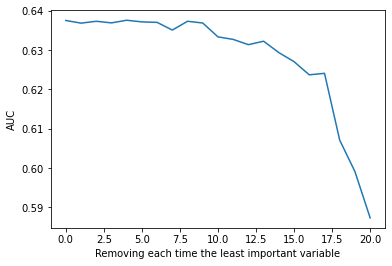

In [72]:
plt.plot([i for i in range(len(auc_per_var))], [i[0] for i in auc_per_var])
plt.xlabel('Removing each time the least important variable')
plt.ylabel('AUC')

In [ ]:
# Save the best model

convert_model(model,input_variables=input_vars,output_xml=os.path.join(save_dir,'xgboost-{}.xml'.format(channel)))